# **Tabular Playground Series - Sep 2022**
www.kaggle.com/competitions/tabular-playground-series-sep-2022

In [18]:
!pip install opendatasets

#Roba per il modello fbprophet
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 1.2 MB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.7 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638409 sha256=2e5b1e681c35f82a67efcfebfc51d7834ce32d08188f3ddf4da1bcd8c917d339
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninsta

In [2]:
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import opendatasets as od
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
dataset_link = 'www.kaggle.com/competitions/tabular-playground-series-sep-2022'

In [4]:
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: marianocaccavale
Your Kaggle Key: ··········


100%|██████████| 615k/615k [00:00<00:00, 58.9MB/s]


Extracting archive ./tabular-playground-series-sep-2022/tabular-playground-series-sep-2022.zip to ./tabular-playground-series-sep-2022


In [5]:
train_dataset_link = "./tabular-playground-series-sep-2022/train.csv"
test_dataset_link = "./tabular-playground-series-sep-2022/test.csv"
submission_link = "./tabular-playground-series-sep-2022/sample_submission.csv"

In [6]:
train_dataset = pd.read_csv(train_dataset_link, index_col = "row_id", parse_dates=['date'])
test_dataset = pd.read_csv(test_dataset_link, index_col = "row_id", parse_dates=['date'])

In [55]:
X_train = train_dataset.copy()
y_train = X_train.pop("num_sold")

X_test = test_dataset.copy()

In [ ]:
X_train["product"].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

Rendere la variabile "store", la variabile "country", e la variabile "product". Inserire la variabile del lag e le curve di Fourier.


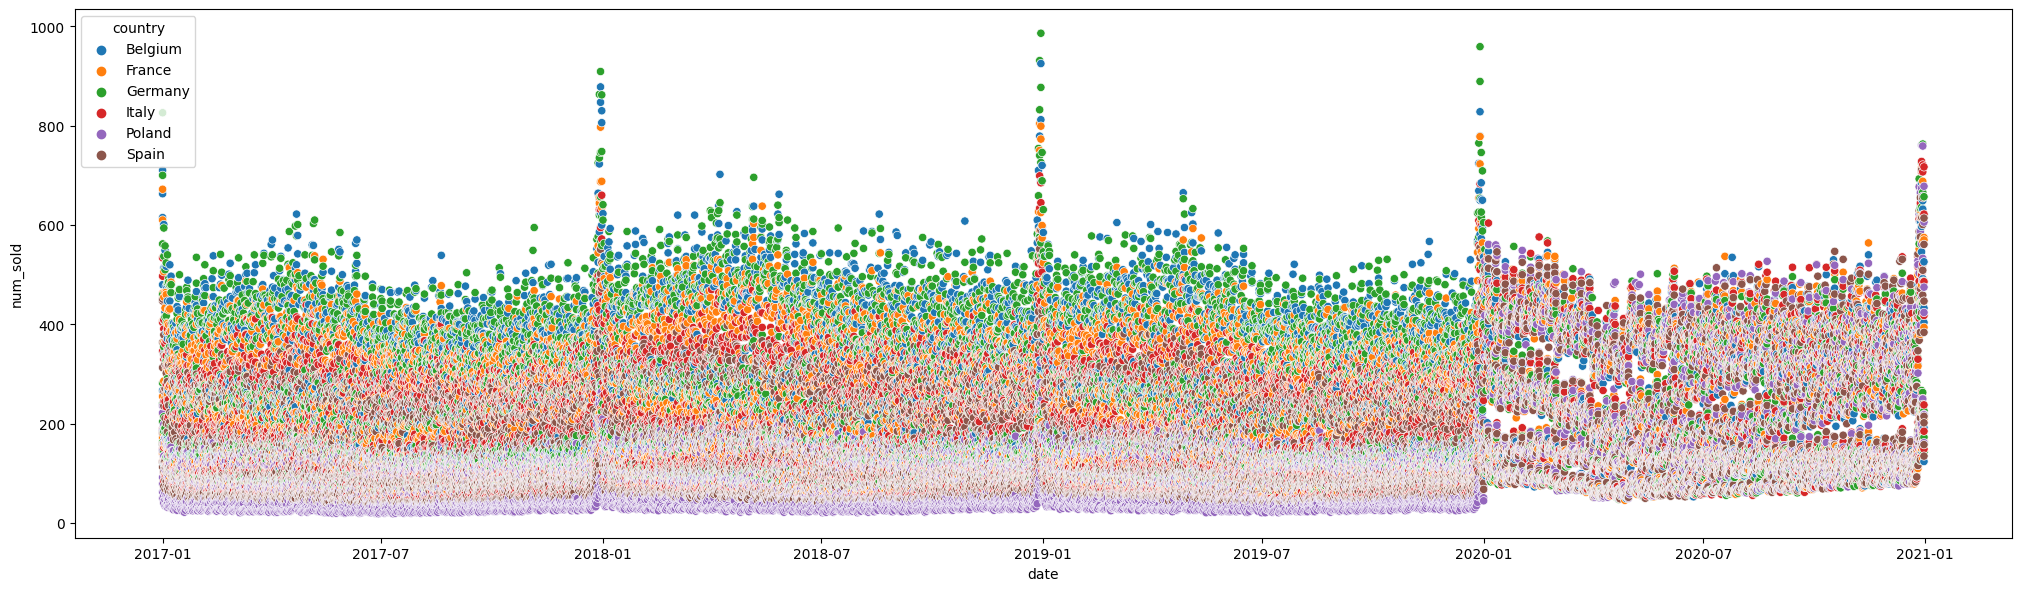

In [ ]:
plt.figure(dpi=100, figsize=(25, 7))
sns.scatterplot(x = "date", y = "num_sold", data = train_dataset, hue = "country")

In [ ]:
X_train

date  country       store                           product  \
row_id                                                                     
0      2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1      2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2      2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3      2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4      2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   
...           ...      ...         ...                               ...   
70123  2020-12-31    Spain  KaggleMart  Kaggle for Kids: One Smart Goose   
70124  2020-12-31    Spain  KaggleRama        Kaggle Advanced Techniques   
70125  2020-12-31    Spain  KaggleRama            Kaggle Getting Started   
70126  2020-12-31    Spain  KaggleRama                Kaggle Recipe Book   
70127  2020-12-31    Spain  KaggleRama  Kaggle for Kids: One Smart Goose   

        num_sold  
row_id            
0            663  
1            615  
2            480  
3            710  
4            240  
...          ...  
70123        614  
70124        215  
70125        158  
70126        135  
70127        202  

[70128 rows x 5 columns]

# **Trend**

Per prima cosa faccio l'analisi di eventuali trend tramite moving average

In [ ]:
mov_avr_ds = pd.DataFrame(index = train_dataset.index, data = train_dataset['num_sold'])
mov_avr_ds['date'] = train_dataset['date']
mov_avr_ds = mov_avr_ds.set_index("date")

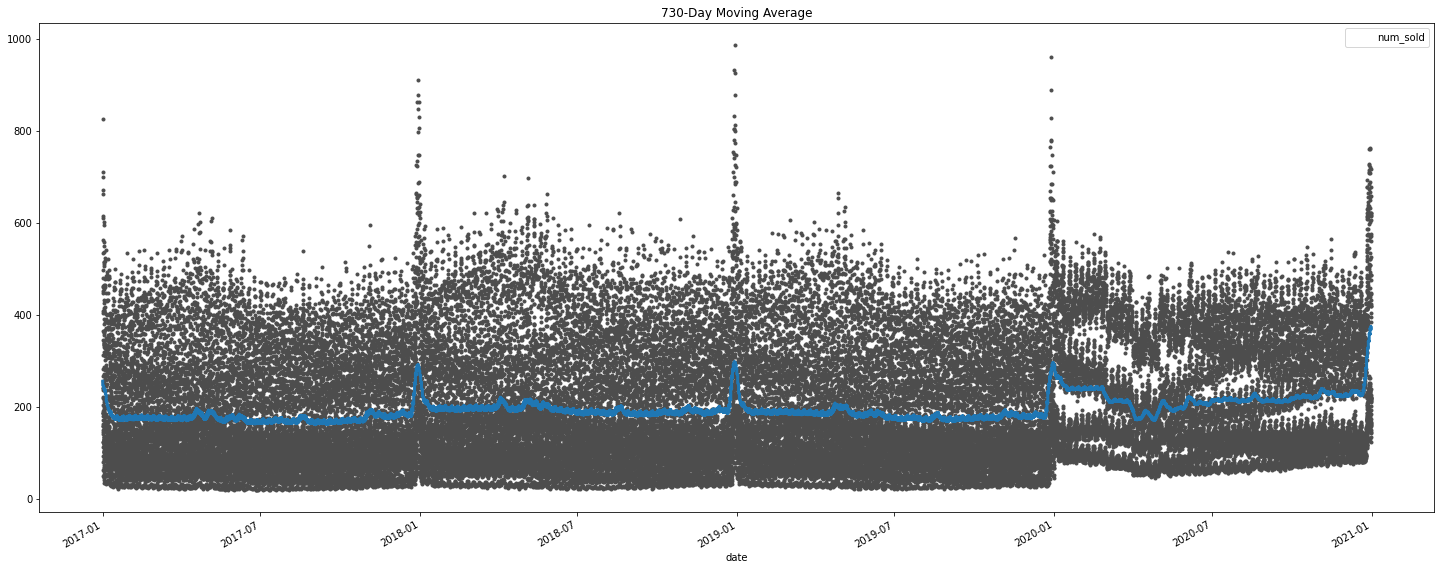

In [ ]:
moving_average = mov_avr_ds.rolling(
    window=365,       # 730-day window
    center=True,      # puts the average at the center of the window
    min_periods=182,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = mov_avr_ds.plot(style=".", color="0.3")
moving_average.plot(
    ax=ax, linewidth=3, title="730-Day Moving Average", legend=False, figsize = (25, 10)
)

Sembrano essercidei picchi di vendita ad inizio anno, inoltre nel 2020 le vendite sono state più rare e irregolari, anche se indicano una maggiore media di vendita sul medio periodo rispetto agli stessi dati degli anni precedenti. Testo queste intuizioni provando a prevedere delle vendite basandomi semplicemente sul MA.

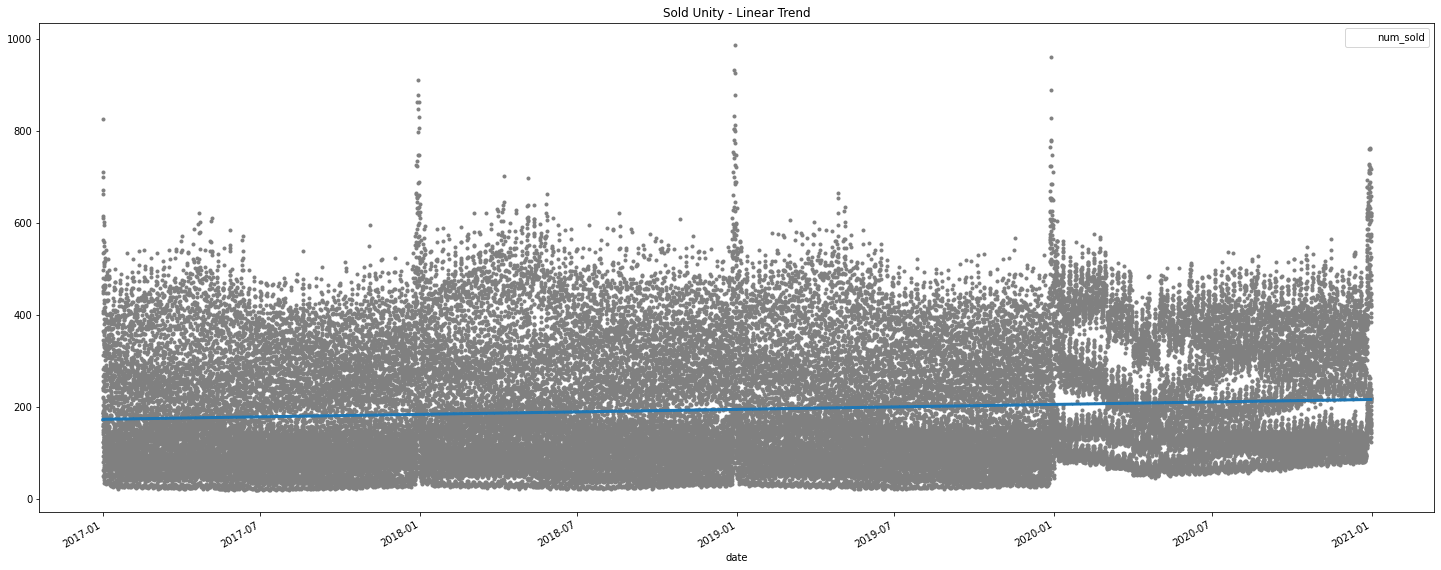

In [ ]:
det_proc = DeterministicProcess(
              index = mov_avr_ds.index, # dati su cui basarsi
              constant = True, # usare il bias per spostare la linea di previsione sull'asse delle y
              order = 1, # ordine della funzione di previsione. Dato che sembra abbastanza lineare, uso ordine 1(x * time + b) 
              drop = True # nel caso droppa le row problematiche
              )
x = det_proc.in_sample()
x.head()

lr = LinearRegression(fit_intercept = False) #import a false l'intercept perchè lo tengo in conto già nel processo deterministico
y = mov_avr_ds['num_sold']

lr.fit(x, y)
y_pred_ma = pd.Series(lr.predict(x), index = x.index)

ax = mov_avr_ds.plot(style=".", color="0.5", title="Sold Unity - Linear Trend")
_ = y_pred_ma.plot(ax=ax, linewidth=3, label="Trend", figsize = (25, 10))

Il modello lineare sembra prevedere abbastanza bene il trend. Proviamo ora con dati fuori dal dataset.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


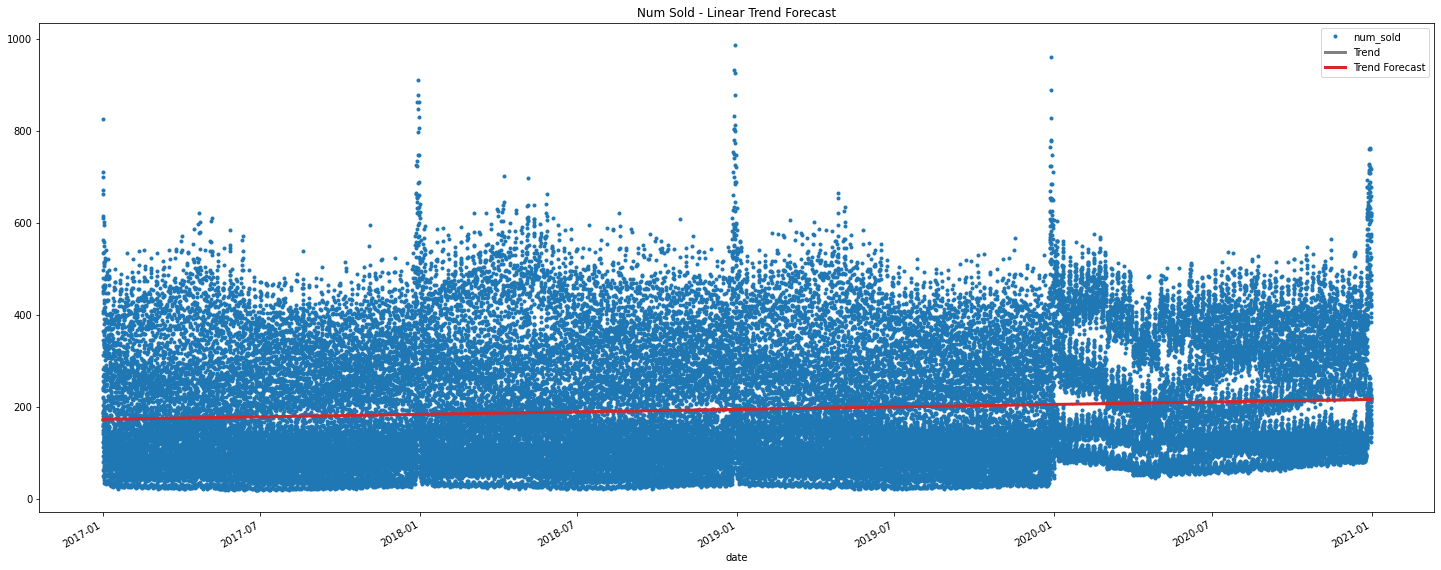

In [ ]:
X_out_sample = det_proc.out_of_sample(steps = 365)

y_out_sample_pred = pd.Series(lr.predict(X_out_sample), index = X_out_sample.index)
y_out_sample_pred.head()


ax = mov_avr_ds["2017-01":].plot(title="Num Sold - Linear Trend Forecast", style = ".", figsize = (25, 10))
ax = y_out_sample_pred[70129:].plot(ax=ax, linewidth=3, color="0.5", label="Trend")
ax = y_pred_ma.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3", figsize = (25, 10))
_ = ax.legend()

Essendo una serie temporale ne studio stagionalità, cicli, etc.

# **Stagionalità**

In [ ]:
# annotations: https://stackoverflow.com/a/49238256/5769929
#Si ringrazia il corso sulle serie temporali di kaggla(YOINK)

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots( figsize = (15, 5))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Per prima cosa, la **stagionalità**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version


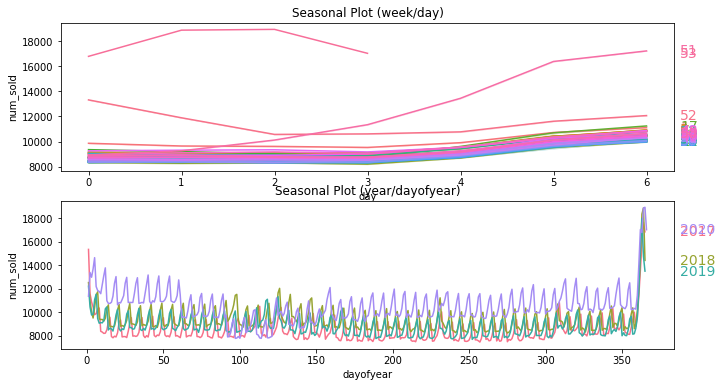

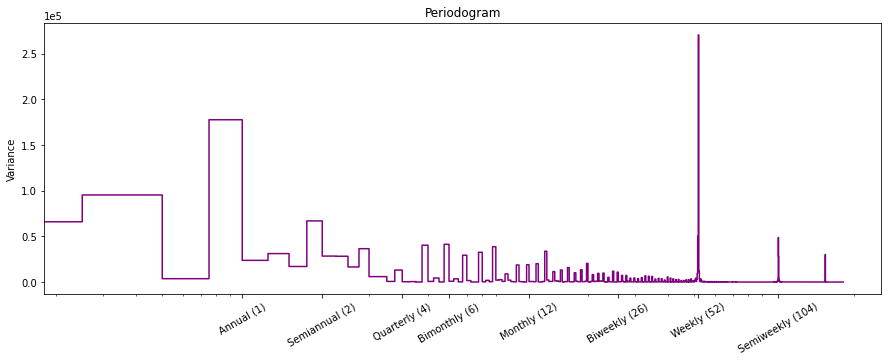

In [ ]:
X_seas = train_dataset.copy()
X_seas = X_seas.set_index("date").to_period("D")

# Numero di vendite totali per data
tot_num_sold = X_seas.groupby("date")["num_sold"].sum()
# Riverso tutto in un dataframe per avere i dati organizzati(e non una serie) e con l'indice giusto, ovvero 'date'
tot_num_sold = pd.DataFrame({'date': tot_num_sold.index, 'num_sold': tot_num_sold.values})
# Cambio l'index per plottare meglio sotto(in seasonal_plot)
tot_num_sold = tot_num_sold.set_index('date')

# Mi creo la colonna dei giorni, in modo che ogni data(oltre al numero di copie totali,
# abbia anche il numero del giorno nella settimana(indicato dalla data))
tot_num_sold['day'] = tot_num_sold.index.dayofweek
# Idem per le settimane
tot_num_sold['week'] = tot_num_sold.index.week

# Idem per i giorni nell'anno(1, 2, ..., 365)
tot_num_sold['dayofyear'] = tot_num_sold.index.dayofyear
# Idem per gli anni
tot_num_sold['year'] = tot_num_sold.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(tot_num_sold, y="num_sold", period="week", freq="day", ax=ax0)
seasonal_plot(tot_num_sold, y="num_sold", period="year", freq="dayofyear", ax=ax1)

plot_periodogram(tot_num_sold['num_sold'])

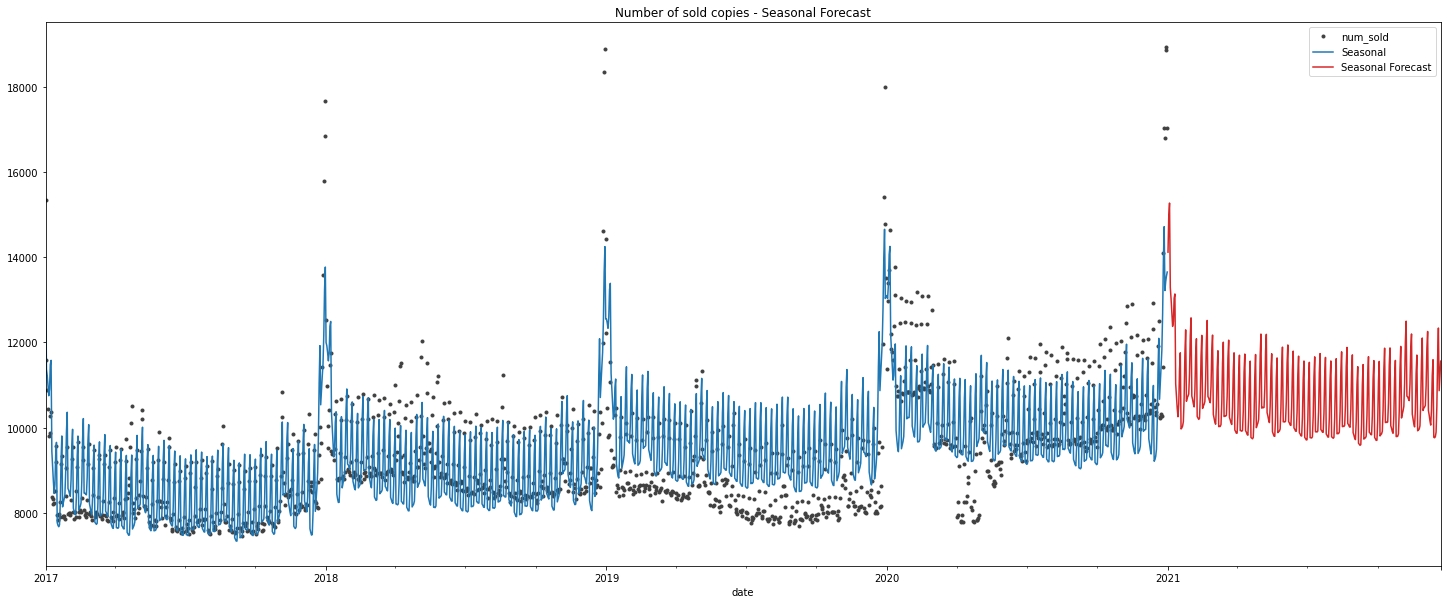

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=15)  # 15 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tot_num_sold.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

y = tot_num_sold["num_sold"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=356)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Number of sold copies - Seasonal Forecast", figsize = (25, 10))
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

Si può chiaramente vedere che c'è una stagionalità annuale e addirittura settimanale. Nel fine settimana le osservazioni ci dicono che vengono effettuati più acquisti.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version


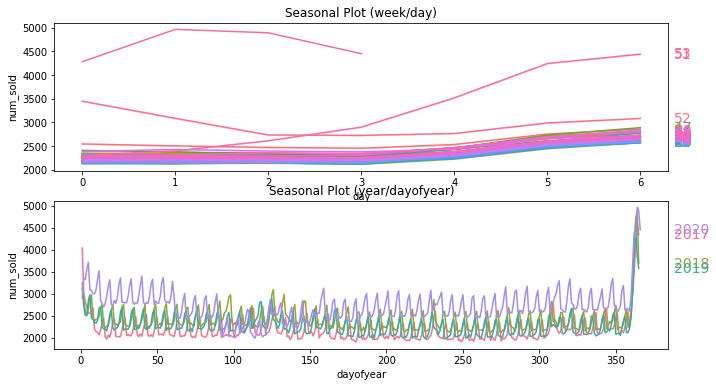

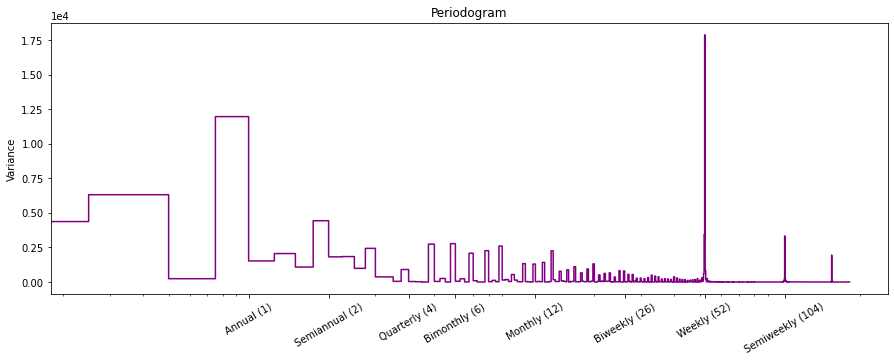

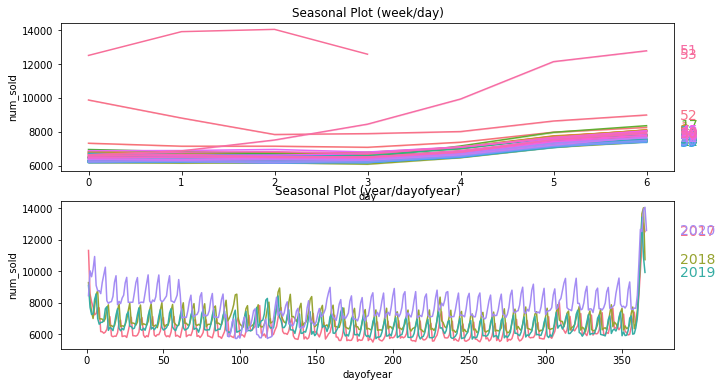

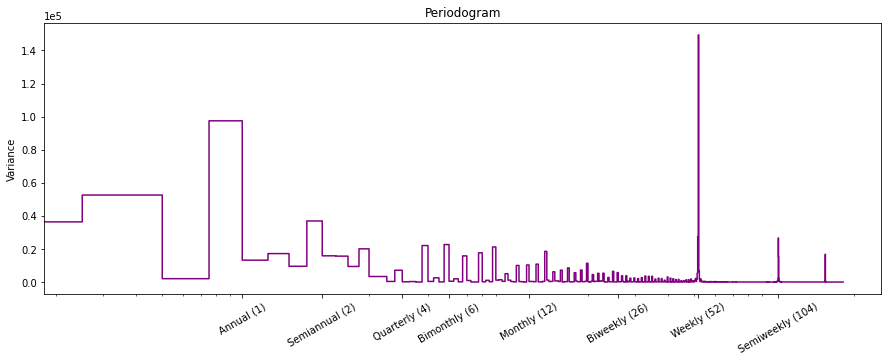

In [ ]:
# Separo le vendite dei due negozi, in modo da poterle studiare indipendentemente
kaggle_rama = X_seas.where(X_seas['store'] == 'KaggleRama').dropna()
kaggle_mart = X_seas.where(X_seas['store'] == 'KaggleMart').dropna()
# Come prima, giorno per giorno calcolo le vendite totali(indipendentemente dalla nazione)
sold_per_store_rama = kaggle_rama.groupby("date")['num_sold'].sum()
sold_per_store_mart = kaggle_mart.groupby("date")['num_sold'].sum()

# Riverso di nuovo tutto in dei dataset
sold_per_store_rama = pd.DataFrame({'date': sold_per_store_rama.index, 'num_sold': sold_per_store_rama.values})
sold_per_store_rama = sold_per_store_rama.set_index('date')
sold_per_store_mart = pd.DataFrame({'date': sold_per_store_mart.index, 'num_sold': sold_per_store_mart.values})
sold_per_store_mart = sold_per_store_mart.set_index('date')

# Colonna dei giorni per il plotting
sold_per_store_rama['day'] = sold_per_store_rama.index.dayofweek
sold_per_store_mart['day'] = sold_per_store_mart.index.dayofweek
# Idem per le settimane
sold_per_store_rama['week'] = sold_per_store_rama.index.week
sold_per_store_mart['week'] = sold_per_store_mart.index.week

# Idem per i giorni nell'anno(1, 2, ..., 365)
sold_per_store_rama['dayofyear'] = sold_per_store_rama.index.dayofyear
sold_per_store_mart['dayofyear'] = sold_per_store_mart.index.dayofyear
# Idem per gli anni
sold_per_store_rama['year'] = sold_per_store_rama.index.year
sold_per_store_mart['year'] = sold_per_store_mart.index.year

fig_rama, (ax0_rama, ax1_rama) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(sold_per_store_rama, y="num_sold", period="week", freq="day", ax=ax0_rama)
seasonal_plot(sold_per_store_rama, y="num_sold", period="year", freq="dayofyear", ax=ax1_rama)
plot_periodogram(sold_per_store_rama['num_sold'])

fig_mart, (ax0_mart, ax1_mart) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(sold_per_store_mart, y="num_sold", period="week", freq="day", ax=ax0_mart)
seasonal_plot(sold_per_store_mart, y="num_sold", period="year", freq="dayofyear", ax=ax1_mart)
plot_periodogram(sold_per_store_mart['num_sold'])

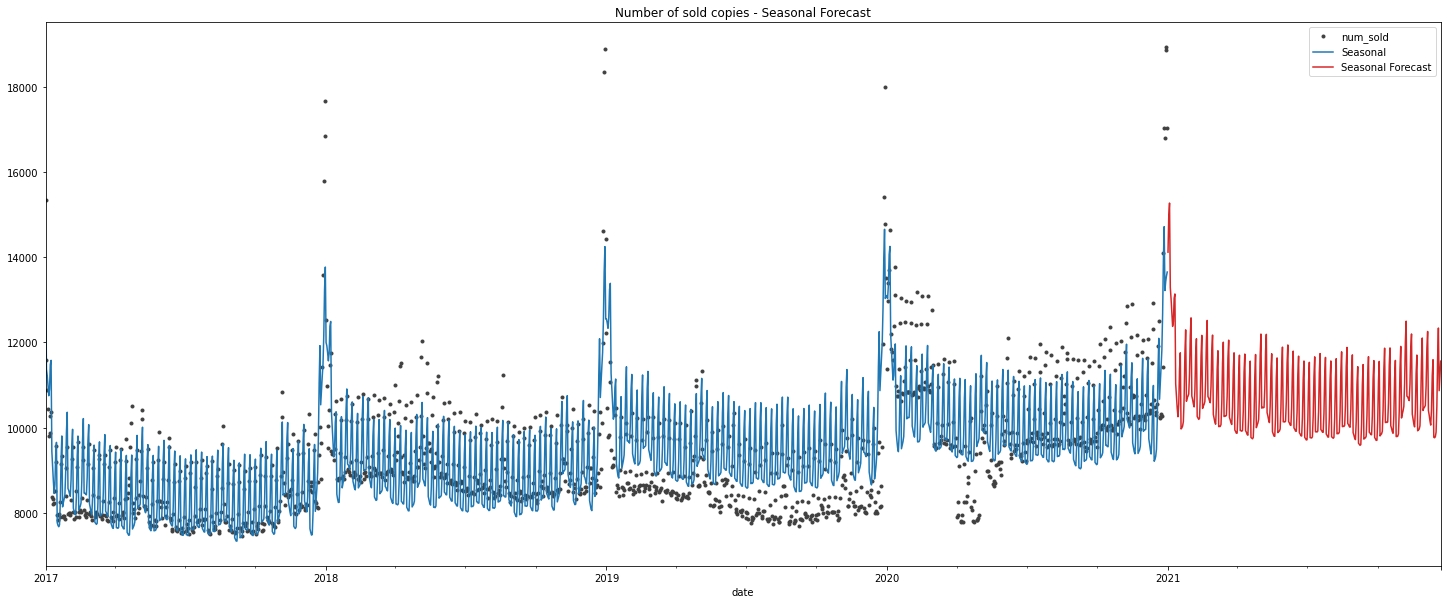

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=15)  # 15 sin/cos pairs for "A"nnual seasonality

dp_rama = DeterministicProcess(
    index=sold_per_store_rama.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_rama = dp.in_sample()

y_rama = tot_num_sold["num_sold"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X_rama, y_rama)

y_pred_rama = pd.Series(model.predict(X_rama), index=y_rama.index)
X_fore_rama = dp_rama.out_of_sample(steps=356)
y_fore_rama = pd.Series(model.predict(X_fore_rama), index=X_fore_rama.index)

ax_rama = y.plot(color='0.25', style='.', title="Number of sold copies - Seasonal Forecast", figsize = (25, 10))
ax_rama = y_pred.plot(ax=ax_rama, label="Seasonal")
ax_rama = y_fore.plot(ax=ax_rama, label="Seasonal Forecast", color='C3')
_ = ax_rama.legend()

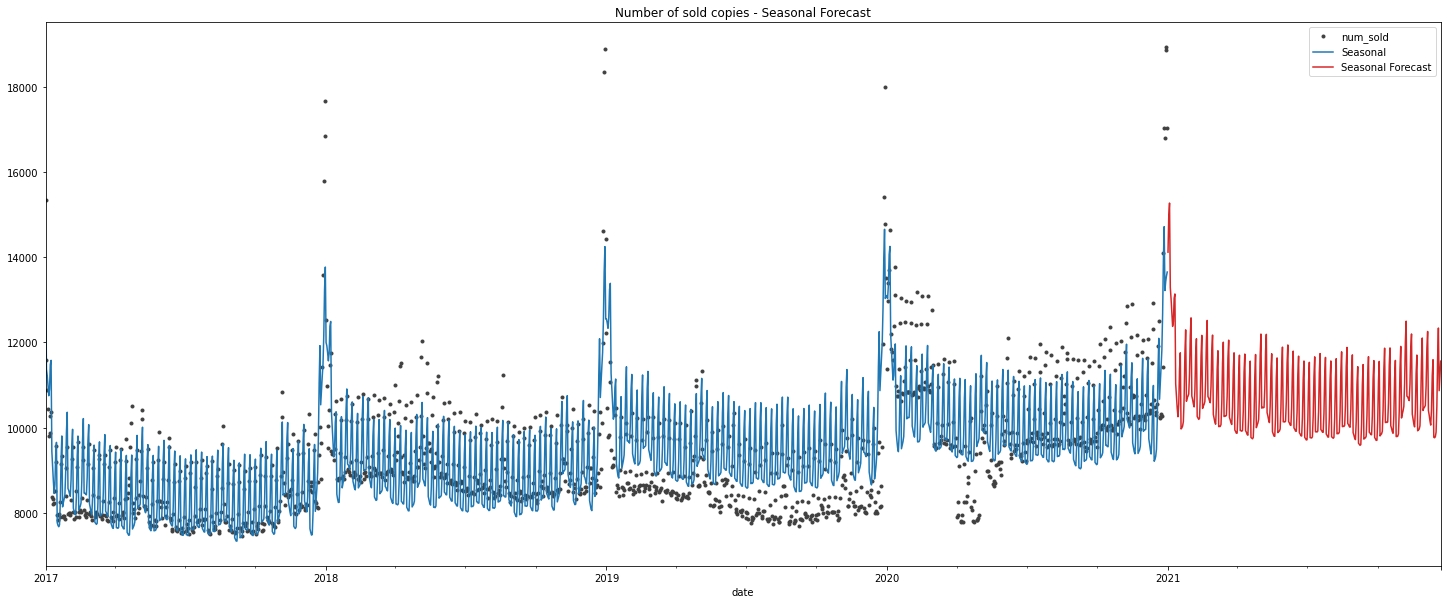

In [ ]:
dp_mart = DeterministicProcess(
    index=sold_per_store_mart.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_mart = dp.in_sample()

y_mart = tot_num_sold["num_sold"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X_mart, y_mart)

y_pred_mart = pd.Series(model.predict(X_mart), index=y_mart.index)
X_fore_mart = dp_mart.out_of_sample(steps=356)
y_fore_mart = pd.Series(model.predict(X_fore_mart), index=X_fore_mart.index)

ax_mart = y.plot(color='0.25', style='.', title="Number of sold copies - Seasonal Forecast", figsize = (25, 10))
ax_mart = y_pred.plot(ax=ax_mart, label="Seasonal")
ax_mart = y_fore.plot(ax=ax_mart, label="Seasonal Forecast", color='C3')
_ = ax_mart.legend()

La stagionalità per i due negozi sembra praticamente essere la stessa, dunque non è una feature/informazione rilevante in questo momento; per tanto termino qui l'analisi della stagionalità

# **Cicli**

In [ ]:
#YOINK
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

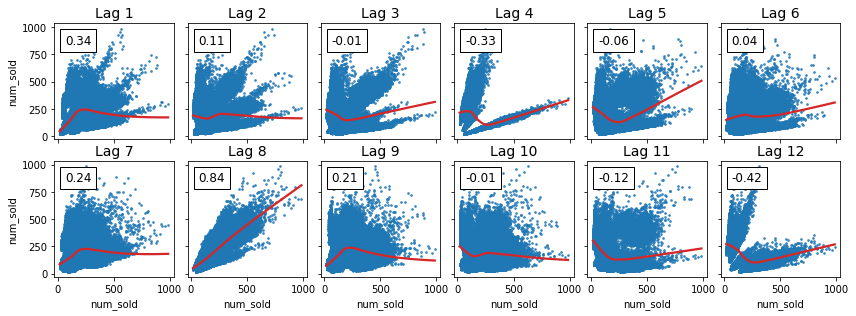

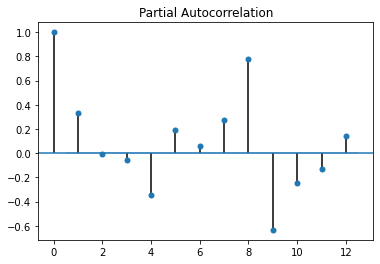

In [ ]:
_ = plot_lags(train_dataset['num_sold'], lags=12, nrows=2)
_ = plot_pacf(train_dataset['num_sold'], lags=12)

I grafici del lag ci dimostrano che c'è una forte correlazione tra il numero di copie vendute un giorno e il numero di copie vendute 8 giorni prima. 

In [ ]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [ ]:
X_regr = make_lags(train_dataset['num_sold'], lags = 8)
X_regr = X_regr.fillna(0.0)
X_train["lag_8"] = X_regr["y_lag_8"]
X_train

date  country       store                           product  \
row_id                                                                     
0      2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1      2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2      2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3      2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4      2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   
...           ...      ...         ...                               ...   
70123  2020-12-31    Spain  KaggleMart  Kaggle for Kids: One Smart Goose   
70124  2020-12-31    Spain  KaggleRama        Kaggle Advanced Techniques   
70125  2020-12-31    Spain  KaggleRama            Kaggle Getting Started   
70126  2020-12-31    Spain  KaggleRama                Kaggle Recipe Book   
70127  2020-12-31    Spain  KaggleRama  Kaggle for Kids: One Smart Goose   

        lag_8  
row_id         
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
...       ...  
70123   678.0  
70124   219.0  
70125   160.0  
70126   162.0  
70127   218.0  

[70128 rows x 5 columns]

Laggata la serie, controllo se la regressione lineare beneficia della serie laggata.

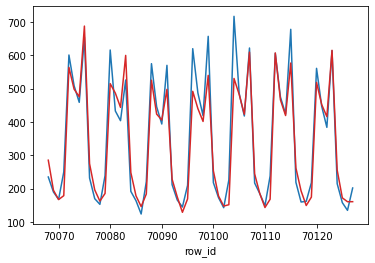

In [ ]:
y_regr = train_dataset.num_sold.copy()
X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(X_regr, y_regr, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()
model.fit(X_train_regr, y_train_regr)
y_pred_regr = pd.Series(model.predict(X_train_regr), index=y_train_regr.index)
y_fore_regr = pd.Series(model.predict(X_test_regr), index=y_test_regr.index)

ax = y_test_regr.plot()
_ = y_fore_regr.plot(ax=ax, color='C3')

Bene o male la previsione effettuata col lag di 8 steps è abbastanza precisa. Quanto meno riesce a seguire e ricalcare i cicli della serie originale.

# **Time series decomposition**

Essendo la serie temporale composta intrinsecamente da diverse componenti, le visualizzo per chiarezza/data visualization.(sostanzialmente sono informazioni che ho già visualizzato prima, ma più compatte e generate da una singola routine. Buona per visualizzare i dati al volo, ma non molto per fare pratica)

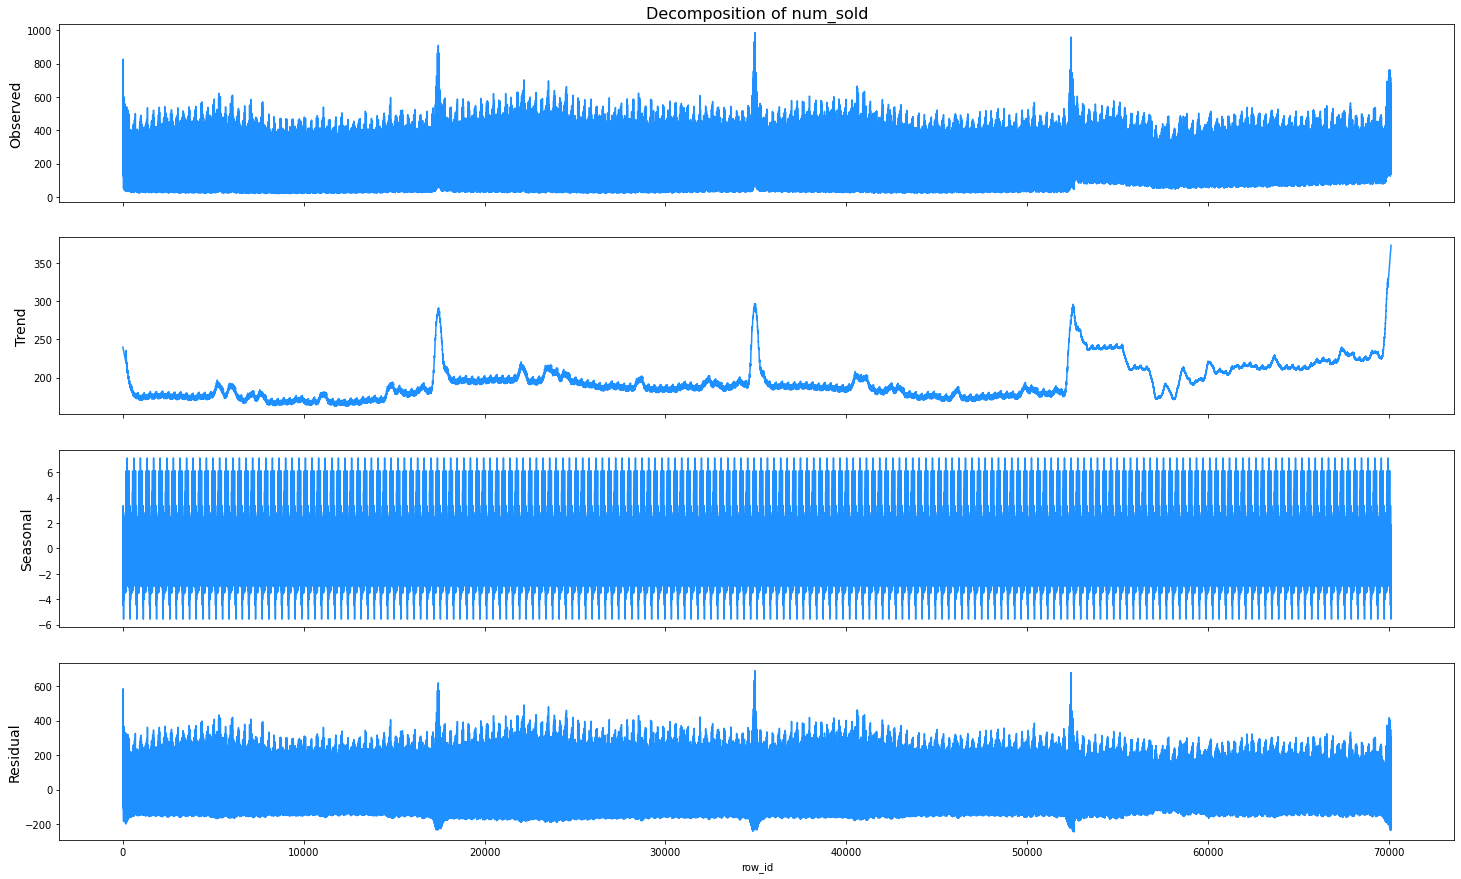

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'num_sold'
]

X_train_visualization = X_train.copy()
X_train_visualization = X_train_visualization.set_index("date")

for column in core_columns:
    decomp = seasonal_decompose(train_dataset[column], period=365, model='additive', extrapolate_trend='freq')
    X_train_visualization[f"{column}_trend"] = decomp.trend
    X_train_visualization[f"{column}_seasonal"] = decomp.seasonal

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(25,15))

res = seasonal_decompose(train_dataset['num_sold'], period=365, model='additive', extrapolate_trend='freq')

ax[0].set_title('Decomposition of {}'.format(column), fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)
    
res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)

plt.show()

# **Feature engineering**

Essendo la feature "Country" contenente solo 5 valori, ed essendo categorica uso dei dummies per codificare le nuove feature. (Droppo la variabile originale in quanto non più utile)

In [56]:
X_train = pd.concat([X_train, pd.DataFrame(index = X_train.index, data =  pd.get_dummies(X_train["country"]))], axis = 1)
X_train.pop("country")

row_id
0        Belgium
1        Belgium
2        Belgium
3        Belgium
4        Belgium
          ...   
70123      Spain
70124      Spain
70125      Spain
70126      Spain
70127      Spain
Name: country, Length: 70128, dtype: object

Essendo la feature "store" contenente solo 2 valori, ed essendo categorica uso dei dummies per codificare le nuove feature. (Droppo la variabile originale in quanto non più utile)

In [57]:
X_train = pd.concat([X_train, pd.DataFrame(index = X_train.index, data =  pd.get_dummies(X_train["store"]))], axis = 1)
X_train.pop("store")

row_id
0        KaggleMart
1        KaggleMart
2        KaggleMart
3        KaggleMart
4        KaggleRama
            ...    
70123    KaggleMart
70124    KaggleRama
70125    KaggleRama
70126    KaggleRama
70127    KaggleRama
Name: store, Length: 70128, dtype: object

Essendo la feature "product" contenente solo 4 valori, ed essendo categorica uso dei dummies per codificare le nuove feature. (Droppo la variabile originale in quanto non più utile)

In [58]:
X_train = pd.concat([X_train, pd.DataFrame(index = X_train.index, data =  pd.get_dummies(X_train["product"]))], axis = 1)
X_train.pop("product")

row_id
0              Kaggle Advanced Techniques
1                  Kaggle Getting Started
2                      Kaggle Recipe Book
3        Kaggle for Kids: One Smart Goose
4              Kaggle Advanced Techniques
                       ...               
70123    Kaggle for Kids: One Smart Goose
70124          Kaggle Advanced Techniques
70125              Kaggle Getting Started
70126                  Kaggle Recipe Book
70127    Kaggle for Kids: One Smart Goose
Name: product, Length: 70128, dtype: object

In [59]:
X_train

date  Belgium  France  Germany  Italy  Poland  Spain  KaggleMart  \
row_id                                                                          
0      2017-01-01        1       0        0      0       0      0           1   
1      2017-01-01        1       0        0      0       0      0           1   
2      2017-01-01        1       0        0      0       0      0           1   
3      2017-01-01        1       0        0      0       0      0           1   
4      2017-01-01        1       0        0      0       0      0           0   
...           ...      ...     ...      ...    ...     ...    ...         ...   
70123  2020-12-31        0       0        0      0       0      1           1   
70124  2020-12-31        0       0        0      0       0      1           0   
70125  2020-12-31        0       0        0      0       0      1           0   
70126  2020-12-31        0       0        0      0       0      1           0   
70127  2020-12-31        0       0        0      0       0      1           0   

        KaggleRama  Kaggle Advanced Techniques  Kaggle Getting Started  \
row_id                                                                   
0                0                           1                       0   
1                0                           0                       1   
2                0                           0                       0   
3                0                           0                       0   
4                1                           1                       0   
...            ...                         ...                     ...   
70123            0                           0                       0   
70124            1                           1                       0   
70125            1                           0                       1   
70126            1                           0                       0   
70127            1                           0                       0   

        Kaggle Recipe Book  Kaggle for Kids: One Smart Goose  
row_id                                                        
0                        0                                 0  
1                        0                                 0  
2                        1                                 0  
3                        0                                 1  
4                        0                                 0  
...                    ...                               ...  
70123                    0                                 1  
70124                    0                                 0  
70125                    0                                 0  
70126                    1                                 0  
70127                    0                                 1  

[70128 rows x 13 columns]

In [33]:
def preprocess_feature(X_in, columns):
  X = X_in.copy()

  for column in columns:
    X = pd.concat([X, pd.DataFrame(index = X.index, data =  pd.get_dummies(X[column]))], axis = 1)
    X.pop(column)

  return X

Dai grafici che abbiamo visto prima, abbiamo notato una forte stagionalità settimanale e annuale, motivo per cui vado ad inserire queste feature nel dataset, in modo da "dare una mano al modello" ad imparare più velocemente queste stagionalità.

In [34]:
def encode_stagionality(X, date_col = 'date', inPlace = True):

  X_tmp = X

  if not inPlace:
      X_tmp = X.copy()

  X_tmp['dayofweek'] = X_tmp[date_col].dt.dayofweek
  X_tmp['dayofyear'] = X_tmp[date_col].dt.dayofyear
  X_tmp['year'] =  X_tmp[date_col].dt.year

  return X_tmp

In [60]:
X_test = preprocess_feature(X_test, ["country", "store", "product"])

In [61]:
X_train = encode_stagionality(X_train, date_col = 'date')
X_test = encode_stagionality(X_test, date_col = 'date')

X_test

date  Belgium  France  Germany  Italy  Poland  Spain  KaggleMart  \
row_id                                                                          
70128  2021-01-01        1       0        0      0       0      0           1   
70129  2021-01-01        1       0        0      0       0      0           1   
70130  2021-01-01        1       0        0      0       0      0           1   
70131  2021-01-01        1       0        0      0       0      0           1   
70132  2021-01-01        1       0        0      0       0      0           0   
...           ...      ...     ...      ...    ...     ...    ...         ...   
87643  2021-12-31        0       0        0      0       0      1           1   
87644  2021-12-31        0       0        0      0       0      1           0   
87645  2021-12-31        0       0        0      0       0      1           0   
87646  2021-12-31        0       0        0      0       0      1           0   
87647  2021-12-31        0       0        0      0       0      1           0   

        KaggleRama  Kaggle Advanced Techniques  Kaggle Getting Started  \
row_id                                                                   
70128            0                           1                       0   
70129            0                           0                       1   
70130            0                           0                       0   
70131            0                           0                       0   
70132            1                           1                       0   
...            ...                         ...                     ...   
87643            0                           0                       0   
87644            1                           1                       0   
87645            1                           0                       1   
87646            1                           0                       0   
87647            1                           0                       0   

        Kaggle Recipe Book  Kaggle for Kids: One Smart Goose  dayofweek  \
row_id                                                                    
70128                    0                                 0          4   
70129                    0                                 0          4   
70130                    1                                 0          4   
70131                    0                                 1          4   
70132                    0                                 0          4   
...                    ...                               ...        ...   
87643                    0                                 1          4   
87644                    0                                 0          4   
87645                    0                                 0          4   
87646                    1                                 0          4   
87647                    0                                 1          4   

        dayofyear  year  
row_id                   
70128           1  2021  
70129           1  2021  
70130           1  2021  
70131           1  2021  
70132           1  2021  
...           ...   ...  
87643         365  2021  
87644         365  2021  
87645         365  2021  
87646         365  2021  
87647         365  2021  

[17520 rows x 16 columns]

In [62]:
X_train

date  Belgium  France  Germany  Italy  Poland  Spain  KaggleMart  \
row_id                                                                          
0      2017-01-01        1       0        0      0       0      0           1   
1      2017-01-01        1       0        0      0       0      0           1   
2      2017-01-01        1       0        0      0       0      0           1   
3      2017-01-01        1       0        0      0       0      0           1   
4      2017-01-01        1       0        0      0       0      0           0   
...           ...      ...     ...      ...    ...     ...    ...         ...   
70123  2020-12-31        0       0        0      0       0      1           1   
70124  2020-12-31        0       0        0      0       0      1           0   
70125  2020-12-31        0       0        0      0       0      1           0   
70126  2020-12-31        0       0        0      0       0      1           0   
70127  2020-12-31        0       0        0      0       0      1           0   

        KaggleRama  Kaggle Advanced Techniques  Kaggle Getting Started  \
row_id                                                                   
0                0                           1                       0   
1                0                           0                       1   
2                0                           0                       0   
3                0                           0                       0   
4                1                           1                       0   
...            ...                         ...                     ...   
70123            0                           0                       0   
70124            1                           1                       0   
70125            1                           0                       1   
70126            1                           0                       0   
70127            1                           0                       0   

        Kaggle Recipe Book  Kaggle for Kids: One Smart Goose  dayofweek  \
row_id                                                                    
0                        0                                 0          6   
1                        0                                 0          6   
2                        1                                 0          6   
3                        0                                 1          6   
4                        0                                 0          6   
...                    ...                               ...        ...   
70123                    0                                 1          3   
70124                    0                                 0          3   
70125                    0                                 0          3   
70126                    1                                 0          3   
70127                    0                                 1          3   

        dayofyear  year  
row_id                   
0               1  2017  
1               1  2017  
2               1  2017  
3               1  2017  
4               1  2017  
...           ...   ...  
70123         366  2020  
70124         366  2020  
70125         366  2020  
70126         366  2020  
70127         366  2020  

[70128 rows x 16 columns]

Dovrei introdurre il lag di 8 giorni anche nel modello di test, come attributo, ma non posso farlo in quanto non ho dati da laggare

In [ ]:
X_regr = make_lags(train_dataset['num_sold'], lags = 8)
X_regr = X_regr.fillna(0.0)
X_regr
X_test["lag_8"] = X_regr["y_lag_8"].values
X_test

# **Data preprocessing**

Per usare buona parte dei modelli di forecasting, dobbiamo fare l'assunzione che i dati siano stazionari(abbiano media e varianza fissi, o che si muovano in un determinato ma ristretto intervallo). Questa assunzione però non può essere fatta ad occhi chiusi, altrimenti il modello restituirà dati errati, motivo per cui studiamo la stazionarità.

La stazionarità di una serie temporale si può rilevare in diversi modi, uno dei più comuni è visualizzando i dati e decidendo. Metodo molto empirico ma che può funzionare per serie palesemente non stazionarie.
Uno dei metodi grafici è l'autocorrelation plot, che mette in correlazione una feature in una determinata data x con una sue versione laggata. Se l'autocorrelazione tende velocemente a 0, abbiamo stazionarità 

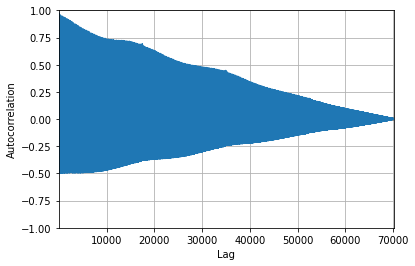

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(train_dataset['num_sold'])
plt.show()

Un altro metodo, più teorico invece, è quello del test Dickey-Fuller; questo metodo cerca di rilevare una radice unitaria nella sere temporale, e se la trova questo vuol dire che la serie non è stazionaria(le radici unitarie sono causa di non stazionarità dei dati).

Ci sono due modi di rilevare l'assenza di una radice unitaria(e quindi la stazionarità):

1.   Se la p-value è sotto un threshold significativo, empiricamente 5%
2.   Se il test statistico è minore del valore critico


In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_dataset['num_sold'].values)
result

(-14.545027605256537,
 5.0731588571254445e-27,
 62,
 70065,
 {'1%': -3.430443335325679,
  '5%': -2.8615812525574507,
  '10%': -2.5667919573266444},
 615162.6776039767)

# **Forecasting**

Devo trasformare la colonna della data 

In [ ]:
X_train.date = pd.to_numeric(X_train.date)
X_train

X_test.date = pd.to_numeric(X_test.date)

In [ ]:
X_train.date = pd.to_datetime(X_train.date)
X_train

X_test.date = pd.to_datetime(X_test.date)

In [ ]:
# Cancello la feature del lag, dato che non so come gestirla nel dataset di test
X_train.pop("lag_8")

Per usare fb prophet con più variabile over time, dobbiamo effettuare un po' di modifiche

In [ ]:
X_train.head()

date  num_sold  Belgium  France  Germany  Italy  Poland  Spain  \
row_id                                                                        
0      2017-01-01       663        1       0        0      0       0      0   
1      2017-01-01       615        1       0        0      0       0      0   
2      2017-01-01       480        1       0        0      0       0      0   
3      2017-01-01       710        1       0        0      0       0      0   
4      2017-01-01       240        1       0        0      0       0      0   

        KaggleMart  KaggleRama  Kaggle Advanced Techniques  \
row_id                                                       
0                1           0                           1   
1                1           0                           0   
2                1           0                           0   
3                1           0                           0   
4                0           1                           1   

        Kaggle Getting Started  Kaggle Recipe Book  \
row_id                                               
0                            0                   0   
1                            1                   0   
2                            0                   1   
3                            0                   0   
4                            0                   0   

        Kaggle for Kids: One Smart Goose  dayofweek  dayofyear  year  
row_id                                                                
0                                      0          6          1  2017  
1                                      0          6          1  2017  
2                                      0          6          1  2017  
3                                      1          6          1  2017  
4                                      0          6          1  2017

In [16]:
feature_columns = [
    'Belgium',
    'France',
    'Germany',
    'Italy',
    'Poland',
    'Spain',
    'KaggleMart',
    'KaggleRama',
    'Kaggle Advanced Techniques',
    'Kaggle Getting Started',
    'Kaggle Recipe Book',
    'Kaggle for Kids: One Smart Goose',
    'dayofweek',
    'dayofyear',
    'year'
]

target_column = ['num_sold']

train_size = int(0.85 * len(X_train))

#multivariate_df = X_train[['date'] + target_column + feature_columns].copy()
#multivariate_df.columns = ['ds', 'y'] + feature_columns

multivariate_df = X_train[['date'] + target_column].copy()
multivariate_df.columns = ['ds', 'y']

train = multivariate_df.iloc[:train_size, :]
#x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
#x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, 0]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, 0]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

ds    y
row_id                
0      2017-01-01  663
1      2017-01-01  615
2      2017-01-01  480
3      2017-01-01  710
4      2017-01-01  240

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math

from fbprophet import Prophet

fbmodel = Prophet()

#for feature in feature_columns:
    #fbmodel.add_regressor(feature)

fbmodel.fit(train)

y_pred = fbmodel.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_smape = mean_absolute_percentage_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('MAE: {}'.format(score_mae))
print('SMAPE: {}'.format(score_smape))
print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 107.9042961487086
SMAPE: 0.6012142060991754
RMSE: 126.29285410132736


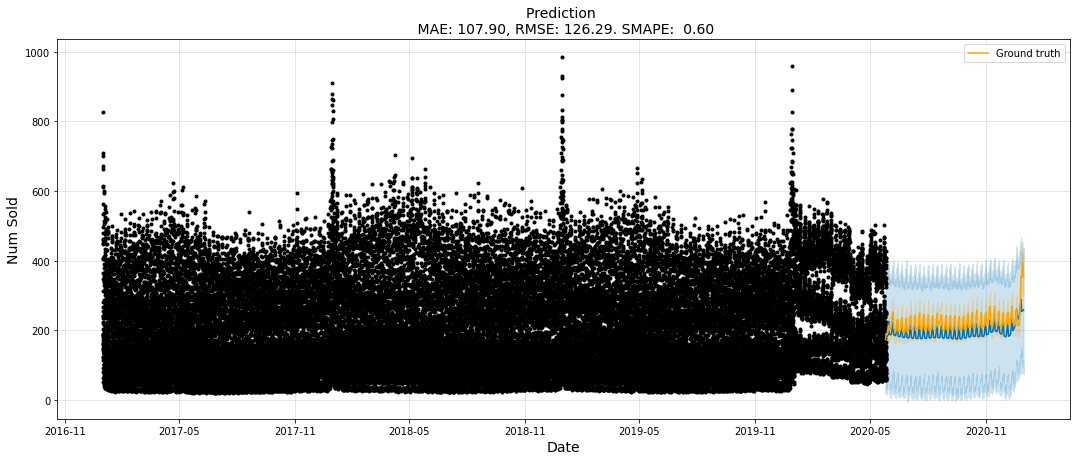

In [44]:
#YOINKS

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

fbmodel.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}. SMAPE: {score_smape: .2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Num Sold', fontsize=14)

plt.show()

In [21]:
X_test.rename(columns= {'date': 'ds'}, inplace=True)

In [22]:
y_test = fbmodel.predict(X_test)

In [ ]:
y_test['yhat']

In [ ]:
submission = pd.read_csv(submission_link)
submission['num_sold'] = y_test['yhat'].round()
submission

In [76]:
submission.to_csv("./submission_tabular_playground_series_sep_2022.csv", index = False, encoding='utf-8-sig')

**A quanto pare una soluzione basata su un modello non specifico per le serie temporali, ma di machine learning e basta è più immediato e più facile da far funzionare(ottiene anche uno score migliore)**

In [63]:
X_train.date = pd.to_numeric(X_train.date)
X_train

X_test.date = pd.to_numeric(X_test.date)

In [78]:
from sklearn.model_selection import cross_val_score

xgbmodel = XGBRegressor()
xgbmodel.fit(X_train, y_train)

xgb_score = cross_val_score(xgbmodel, X_train, y_train, cv = 3, scoring = 'neg_mean_absolute_error')
xgb_score = -xgb_score.mean()
xgb_score

[17:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [73]:
y_hat_pred = xgbmodel.predict(X_test)

In [74]:
y_hat_pred

array([440.34845, 353.14233, 307.52737, ..., 196.1146 , 168.42831,
       234.7763 ], dtype=float32)

In [ ]:
submission = pd.read_csv(submission_link)
submission['num_sold'] = y_hat_pred.round()
submission